# Packages & functions

In [3]:
#
env = 'colab' # 'colab' # 'pc'  # 'colab'

using_gpu = True

train_percentage = 0.5  # how much of train set we will use
val_percentage = 0.5
test_percentage = 0.5

saving_models = True
save_dir = '/content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/24-01-22/'  # 'C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels/2022-01-23/'


In [4]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/main/'
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            
            'Utils.py',
             
             'BNModel.py',
             'CNNModel.py',
             'DropoutModel.py',
             'InceptionModel.py',
             'Model.py',
             'ResNetModel.py'
    ]
    url_dict = {file: path + file for file in files}
    download_files(url_dict)

In [9]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir

In [10]:
# Models
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir
from datetime import date
import pandas as pd

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import ResNetModel
import DropoutModel
import InceptionModel
import Model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,
        CNNModel,
        BNModel,
        DropoutModel,
        Model,
        ResNetModel,
        InceptionModel
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel
from ResNetModel import ResNetModel
from InceptionModel import InceptionModel

In [14]:
DataProps = DataProperties(environment = env)

# Data download

## Paths download

In [15]:
assert isdir(DataProps.train_data_path) == True
assert isdir(DataProps.test_data_path) == True

In [16]:
def calc_files(directory):
    total_files = 0

    for base, _, files in os.walk(directory):
        # print('Searching in : ',base)
        for _ in files:
            total_files += 1
    return total_files

In [17]:
train_files = calc_files(directory = DataProps.train_data_path)
train_covid_files = calc_files(DataProps.train_covid_path)
train_pn_files = calc_files(DataProps.train_pneumonia_path)
train_healthy_files = calc_files(DataProps.train_healthy_path)

# assert train_files == (train_covid_files + train_pn_files + train_healthy_files)

In [18]:
val_files = calc_files(directory = DataProps.val_data_path)
val_covid_files = calc_files(DataProps.val_covid_path)
val_pn_files = calc_files(DataProps.val_pneumonia_path)
val_healthy_files = calc_files(DataProps.val_healthy_path)

assert val_files == (val_covid_files + val_pn_files + val_healthy_files)

In [19]:
test_files = calc_files(DataProps.test_data_path)
test_covid_files = calc_files(DataProps.test_covid_path)
test_pn_files = calc_files(DataProps.test_pneumonia_path)
test_healthy_files = calc_files(DataProps.test_healthy_path)

assert test_files == (test_covid_files + test_pn_files + test_healthy_files)

Text(0, 0.5, 'y')

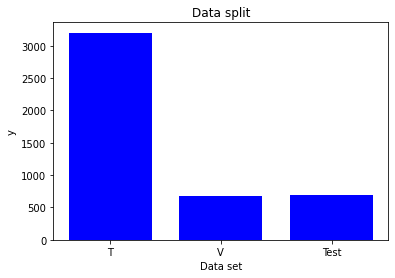

In [20]:
x = ['T', 'V', 'Test']
y = [train_files, val_files, test_files]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.bar(x, y, width, color="blue")
plt.title('Data split')
plt.xlabel('Data set')
plt.ylabel('y') 

# Creating dataset

In [21]:
train_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - train_percentage
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

train_flow = train_generator.flow_from_directory(
    directory = DataProps.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed
)
print(f'Use {train_flow.n} images for train')

Found 1602 images belonging to 3 classes.
Use 1602 images for train


In [22]:
val_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - val_percentage
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

val_flow = train_generator.flow_from_directory(
    directory = DataProps.val_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',  # yes, training - we use val_split of data 
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed
)

print(f'Use {val_flow.n} images for validation')

Found 342 images belonging to 3 classes.
Use 342 images for validation


In [23]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - test_percentage
    # other parameters
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1,
    subset = 'training'
)

print(f'Use {test_flow.n} images for test')

Found 345 images belonging to 3 classes.
Use 345 images for test


In [24]:
assert train_flow.class_indices == test_flow.class_indices
assert train_flow.class_indices == val_flow.class_indices

# Visualizing dataset

(32, 300, 300, 3)


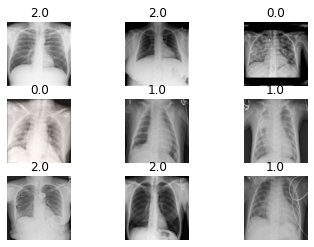

In [ ]:
how_many_to_show = 9
for _ in range(1):
    batch, labels = train_flow.next()
    print(batch.shape)
    assert np.max(batch) <= 1.0
    visualize(batch, labels, how_many_to_show)

# Prepare before training

In [25]:
train_steps = train_flow.n // train_flow.batch_size
validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

what_to_monitor = 'val_loss'
validation_data = val_flow
validation_steps = validation_steps

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = what_to_monitor,
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

print(f'Train steps: {train_steps}')
print(f'Val steps: {validation_steps}')

Train steps: 50
Val steps: 10


In [26]:
if using_gpu:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print(
            '\n\nThis error most likely means that this notebook is not '
            'configured to use a GPU.  Change this in Notebook Settings via the '
            'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
        raise SystemError('GPU device not found')

# CNN architecture

## Fit

In [27]:
cnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'CNN' + '/',
        
    save_weights_only=True,
    monitor = 'val_accuracy',
    mode='max',
    save_best_only = True
)

cnn_model = CNNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = cnn_checkpoint_callback
)
cnn_model.construct_model()
cnn_model.compile_model()

In [29]:
params = {
    'model': cnn_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, cnn_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        cnn_history = fit_(**params)
else:
    cnn_history = fit_(**params)

Fitting with GPU
Epoch 1/500
50/50 [==============================] - 328s 6s/step - loss: 2.0390 - accuracy: 0.5395 - val_loss: 1.1048 - val_accuracy: 0.6313
Epoch 2/500
50/50 [==============================] - 49s 988ms/step - loss: 0.6641 - accuracy: 0.6771 - val_loss: 0.9096 - val_accuracy: 0.6969
Epoch 3/500
50/50 [==============================] - 49s 976ms/step - loss: 0.5386 - accuracy: 0.7739 - val_loss: 0.7648 - val_accuracy: 0.7906
Epoch 4/500
50/50 [==============================] - 50s 996ms/step - loss: 0.4234 - accuracy: 0.8102 - val_loss: 0.7225 - val_accuracy: 0.7688
Epoch 5/500
50/50 [==============================] - 49s 987ms/step - loss: 0.3612 - accuracy: 0.8490 - val_loss: 0.6097 - val_accuracy: 0.7750
Epoch 6/500
50/50 [==============================] - 44s 885ms/step - loss: 0.2856 - accuracy: 0.8936 - val_loss: 0.5224 - val_accuracy: 0.8125
Epoch 7/500
50/50 [==============================] - 44s 873ms/step - loss: 0.3384 - accuracy: 0.8643 - val_loss: 0.7471 

In [30]:
if saving_models:
    print(f'dir: {save_dir + cnn_model.name + "/"}')
    cnn_model.save_model(
        dir = save_dir + cnn_model.name + '/'
    )

dir: /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/24-01-22/CNN/


# Batch normalization

## Fit

In [31]:
bn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'BN' + '/',
        
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only = True
)

bn_model = BNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = bn_checkpoint_callback
)
bn_model.construct_model()
bn_model.compile_model()

# print(cnn_model.model.summary())

In [32]:
params = {
    'model': bn_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, bn_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        bn_history = fit_(**params)
else:
    bn_history = fit_(**params)

Fitting with GPU
Epoch 1/500
50/50 [==============================] - 48s 932ms/step - loss: 10.6898 - accuracy: 0.7185 - val_loss: 1.2908 - val_accuracy: 0.4969
Epoch 2/500
50/50 [==============================] - 45s 911ms/step - loss: 0.2835 - accuracy: 0.9051 - val_loss: 1.9084 - val_accuracy: 0.4500
Epoch 3/500
50/50 [==============================] - 46s 911ms/step - loss: 0.1896 - accuracy: 0.9369 - val_loss: 1.1676 - val_accuracy: 0.4906
Epoch 4/500
50/50 [==============================] - 45s 906ms/step - loss: 0.1646 - accuracy: 0.9452 - val_loss: 1.3637 - val_accuracy: 0.5469
Epoch 5/500
50/50 [==============================] - 44s 884ms/step - loss: 0.0967 - accuracy: 0.9675 - val_loss: 1.2672 - val_accuracy: 0.5531


In [33]:
print(f'dir: {save_dir + bn_model.name + "/"}')
if saving_models:
    bn_model.save_model(
        dir = save_dir + bn_model.name + '/'
    )

dir: /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/24-01-22/BN_CNN/


# Dropout model

## Fit

Dropout / Batch normalization disharmony

In [34]:
dropout_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'Dropout' + '/',
        
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only = True
)

dropout_model = DropoutModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = dropout_checkpoint_callback
)

dropout_model.construct_model()
dropout_model.compile_model()

In [36]:
params = {
    'model': dropout_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, dropout_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        dropout_history = fit_(**params)
else:
    dropout_history = fit_(**params)

Fitting with GPU
Epoch 1/500
50/50 [==============================] - 45s 895ms/step - loss: 0.7127 - accuracy: 0.6892 - val_loss: 0.4280 - val_accuracy: 0.8344
Epoch 2/500
50/50 [==============================] - 45s 892ms/step - loss: 0.3732 - accuracy: 0.8516 - val_loss: 0.3689 - val_accuracy: 0.8719
Epoch 3/500
50/50 [==============================] - 44s 889ms/step - loss: 0.2597 - accuracy: 0.9025 - val_loss: 0.4805 - val_accuracy: 0.8656
Epoch 4/500
50/50 [==============================] - 45s 914ms/step - loss: 0.2080 - accuracy: 0.9236 - val_loss: 0.4236 - val_accuracy: 0.8406


In [37]:
print(f'dir: {save_dir + dropout_model.name + "/"}')
if saving_models:
    dropout_model.save_model(
        dir = save_dir + dropout_model.name + '/'
    )

dir: /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/24-01-22/Dropout_CNN/


# Residual network

In [39]:
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'ResNet' + '/',
        
    save_weights_only=True,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True
)

resnet_model = ResNetModel(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = resnet_checkpoint_callback
)
resnet_model.construct_model()
resnet_model.compile_model()

In [40]:
params = {
    'model': resnet_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, resnet_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        resnet_history = fit_(**params)
else:
    resnet_history = fit_(**params)

Fitting with GPU
Epoch 1/500
50/50 [==============================] - 84s 1s/step - loss: 18.0077 - accuracy: 0.4955 - val_loss: 1531.5955 - val_accuracy: 0.2656
Epoch 2/500
50/50 [==============================] - 69s 1s/step - loss: 4.3415 - accuracy: 0.6803 - val_loss: 8.4596 - val_accuracy: 0.3781
Epoch 3/500
50/50 [==============================] - 70s 1s/step - loss: 3.0023 - accuracy: 0.7401 - val_loss: 2.7813 - val_accuracy: 0.3844
Epoch 4/500
50/50 [==============================] - 69s 1s/step - loss: 3.0178 - accuracy: 0.7166 - val_loss: 13.6772 - val_accuracy: 0.5437
Epoch 5/500
50/50 [==============================] - 70s 1s/step - loss: 2.4709 - accuracy: 0.7796 - val_loss: 1.1634 - val_accuracy: 0.7000
Epoch 6/500
50/50 [==============================] - 71s 1s/step - loss: 0.9682 - accuracy: 0.8115 - val_loss: 0.6775 - val_accuracy: 0.7531
Epoch 7/500
50/50 [==============================] - 70s 1s/step - loss: 1.2319 - accuracy: 0.8255 - val_loss: 45.0446 - val_accurac

In [42]:
print(f'dir: {save_dir + resnet_model.name + "/"}')
if saving_models:
    resnet_model.save_model(
        dir = save_dir + resnet_model.name + '/'
    )

dir: /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/24-01-22/ResNet/


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Inception network

In [43]:
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = \
        DataProps.checkpoint_path + \
        str(date.today()) + '/' + \
        'Inception' + '/',
        
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only = True
)

inception_model = InceptionModel(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = inception_checkpoint_callback
)
inception_model.construct_model()
inception_model.compile_model()

In [44]:
params = {
    'model': inception_model.model,
    'train_flow': train_flow,
    'train_steps': train_steps,

    'val_flow': validation_data,
    'val_steps': validation_steps,

    'epochs': DatasetParameters.epochs,
    'callbacks': [early_stop, inception_model.checkpoint_callback]
}

if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        inception_history = fit_(**params)
else:
    inception_history = fit_(**params)

Fitting with GPU
Epoch 1/500
50/50 [==============================] - 135s 2s/step - loss: 1.0802 - accuracy: 0.4911 - val_loss: 15.2968 - val_accuracy: 0.3562
Epoch 2/500
50/50 [==============================] - 106s 2s/step - loss: 0.7628 - accuracy: 0.6955 - val_loss: 6.6075 - val_accuracy: 0.2906
Epoch 3/500
50/50 [==============================] - 108s 2s/step - loss: 0.5331 - accuracy: 0.7706 - val_loss: 3.3426 - val_accuracy: 0.3562
Epoch 4/500
50/50 [==============================] - 106s 2s/step - loss: 0.5070 - accuracy: 0.7885 - val_loss: 1.9811 - val_accuracy: 0.3063
Epoch 5/500
50/50 [==============================] - 106s 2s/step - loss: 0.4581 - accuracy: 0.8134 - val_loss: 1.3072 - val_accuracy: 0.4000
Epoch 6/500
50/50 [==============================] - 106s 2s/step - loss: 0.3901 - accuracy: 0.8459 - val_loss: 0.5782 - val_accuracy: 0.7500
Epoch 7/500
50/50 [==============================] - 106s 2s/step - loss: 0.3599 - accuracy: 0.8682 - val_loss: 0.8410 - val_accur

In [45]:
print(f'dir: {save_dir + inception_model.name + "/"}')
if saving_models:
    inception_model.save_model(
        dir = save_dir + inception_model.name + '/'
    )

dir: /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/24-01-22/Inception/


# Models evaluation

## Models reload

In [46]:
# Deleting and re-loading everything
models_list = [
    cnn_model, 
    bn_model,
    dropout_model,
    inception_model,
    resnet_model
]
try:
    for m in models_list: #[cnn_model, bn_model, dropout_model, resnet_model, inception_model]:
        if not m is None:
            print('deleting')
            del m
except NameError:
    print('Exception')

deleting
deleting
deleting
deleting
deleting


In [49]:
models = {
    'CNN': None,
    'BN': None,
    'Dropout': None,
    'ResNet': None,
    'Inception': None
}

models['CNN'] = CNNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = cnn_checkpoint_callback
)

models['Dropout'] = DropoutModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = dropout_checkpoint_callback
)

models['BN'] = BNModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = bn_checkpoint_callback
)

models['ResNet'] = ResNetModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = bn_checkpoint_callback
)

models['Inception'] = InceptionModel(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
    checkpoint = bn_checkpoint_callback
)



# Rest of models

In [50]:
for name, model in models.items():
    model.construct_model()
    model.compile_model()
    model.model.load_weights(save_dir + model.name + '/' + f'{model.name}.h5')

## Test flow performance

In [52]:
if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        metrics_dict = collect_metrics(models, test_flow, test_steps)
else:
    metrics_dict = collect_metrics(models, test_flow, test_steps)

Fitting with GPU
345/345 [==============================] - 8s 21ms/step - loss: 1.5743 - accuracy: 0.4609


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


345/345 [==============================] - 32s 73ms/step - loss: 1.1386 - accuracy: 0.6377


In [81]:
test_metrics_df = pd.DataFrame(metrics_dict).transpose()
test_metrics_df['tr_params_norm'] = test_metrics_df['tr_params'] / np.max(test_metrics_df['tr_params'])
test_metrics_df['test_loss^(-1)'] = test_metrics_df['test_loss^(-1)'] / np.max(test_metrics_df['test_loss^(-1)'])

In [82]:
test_metrics_df.head()

,test_loss^(-1),test_accuracy,F1,precision,recall,tr_params,tr_params_norm
CNN,0.505487,0.739130,0.738592,0.744251,0.739130,10788643.0,0.261994
BN,1.000000,0.460870,0.375636,0.418539,0.460870,12001795.0,0.291454
Dropout,0.466173,0.779710,0.780541,0.783028,0.779710,12001059.0,0.291436
ResNet,0.939081,0.684058,0.684446,0.684953,0.684058,23688195.0,0.575249
Inception,0.723280,0.637681,0.631891,0.683167,0.637681,41179011.0,1.000000


In [83]:
test_metrics_df.to_csv(save_dir + 'test_metrics_res.csv')

<Figure size 1080x1080 with 0 Axes>

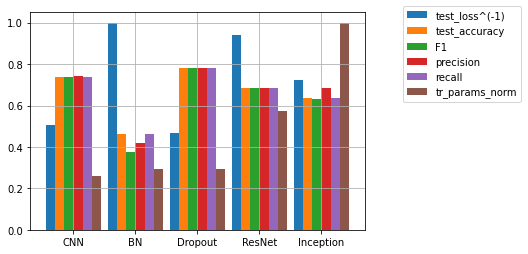

In [85]:
metrics_to_show = [
                   'test_loss^(-1)',
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall',
                   'tr_params_norm'
]

plt.figure(figsize = (15, 15))
ax = test_metrics_df.loc[:, metrics_to_show].plot.bar(
    rot = 0,
    width = 0.9
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

## Confusion matrices

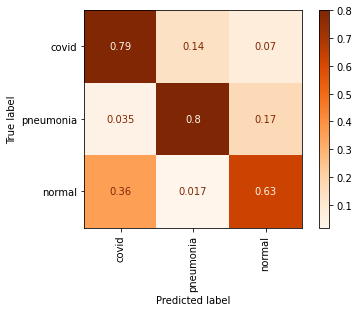

In [63]:
test_flow.reset()
plot_confusion_matrix(
    Y_true = test_flow.classes, 
    Y_pred = models['CNN'].flow_predict(
        test_flow,
        test_steps
    ),
    class_indices = test_flow.class_indices
)

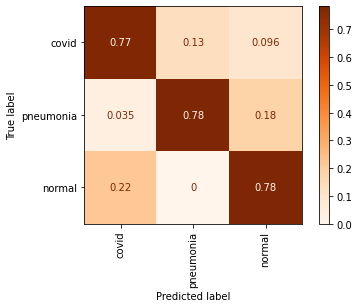

In [77]:
test_flow.reset()
plot_confusion_matrix(
    Y_true = test_flow.classes, 
    Y_pred = models['Dropout'].flow_predict(
        test_flow,
        test_steps
    ),
    class_indices = test_flow.class_indices
)

## Learning curves

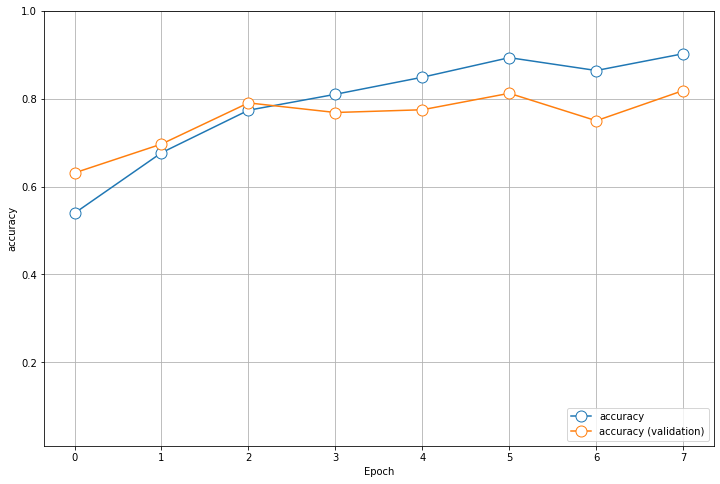

In [64]:
plot_history(
    history = cnn_history.history,
    metrics_name = 'accuracy',
    plot_validation = True
)

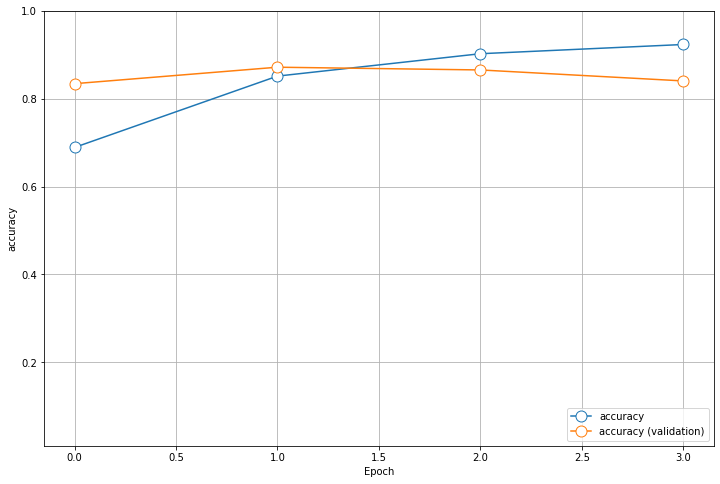

In [65]:
plot_history(
    history = dropout_history.history,
    metrics_name = 'accuracy',
    plot_validation = True
)

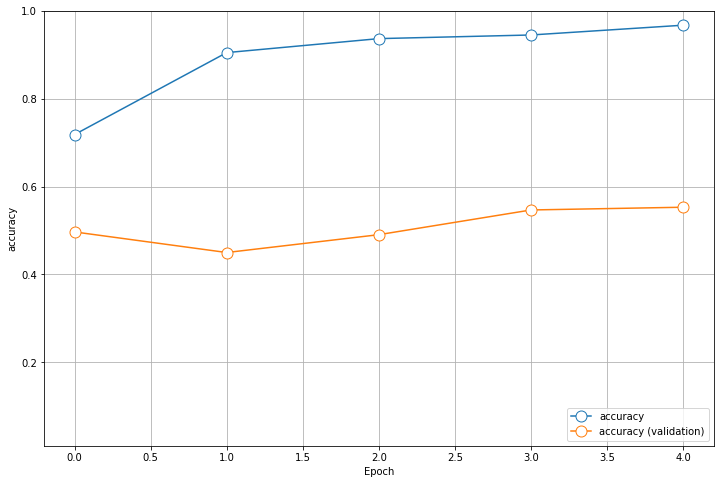

In [66]:
plot_history(
    history = bn_history.history,
    metrics_name = 'accuracy',
    plot_validation = True
)

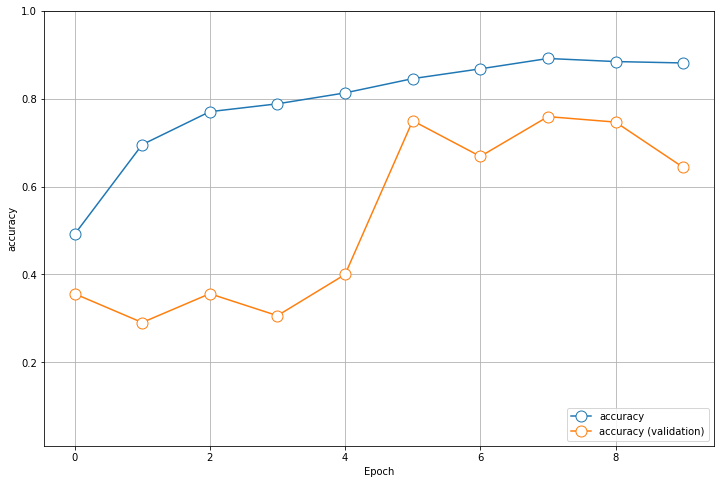

In [67]:
plot_history(
    history = resnet_history.history,
    metrics_name = 'accuracy',
    plot_validation = True
)

In [68]:
plot_history(
    history = inception_history.history,
    metrics_name = 'accuracy',
    plot_validation = True
)

NameError: ignored

## Layers interpretation

We have:
        3 by 3 kernel, 
        of 3 color channels,
        total: 16 kernels


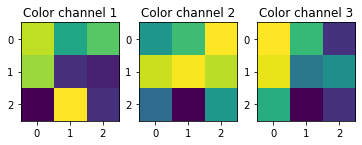

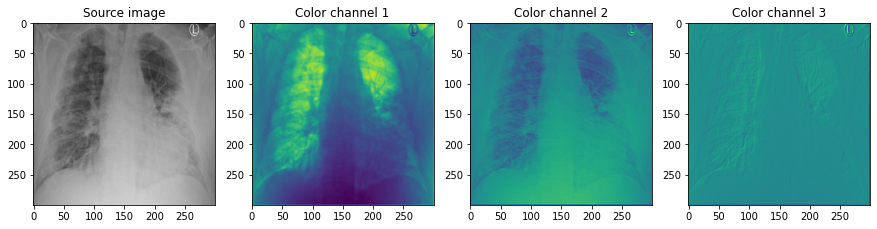

In [69]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 0, 
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

We have:
        3 by 3 kernel, 
        of 16 color channels,
        total: 32 kernels


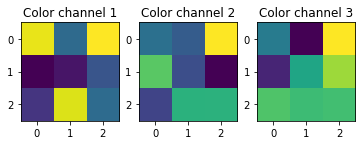

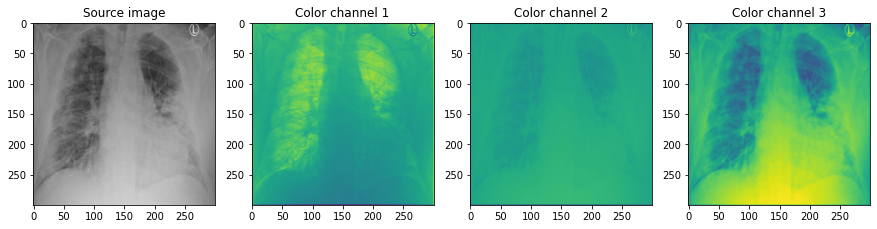

In [70]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 2,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

We have:
        3 by 3 kernel, 
        of 64 color channels,
        total: 256 kernels


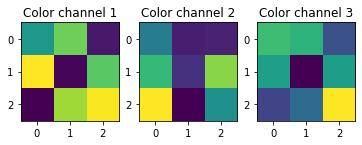

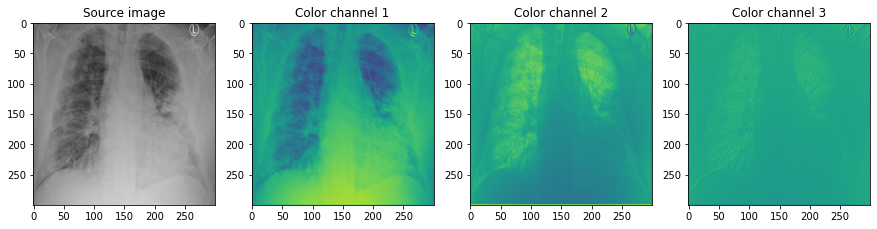

In [76]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 6,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)